In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels

In [2]:
df = pd.read_pickle(r"../base_processed.pkl")

In [3]:
new_column = ['0-13','14-17','18-22','23-25','26-30','31-35','36-40','41-45','46-50','51-60','56-60','61-65','65+']

> В этой клетке содержится код для сэмплирования

In [4]:
# data = []
# for i in range(1, 14):
#     a = df[df['age_category'] == i]
#     # print(len(a))
#     if len(a) >= 1000:
#         data.append(a.sample(1000, random_state=1)) 

# data_more_than_thousand = pd.concat(data)

In [4]:
def f(x):
    if x == 11:
        return 10
    else:
        return x
df.age_category = df.age_category.apply(f)

In [5]:
res_all = pl.from_pandas(df).group_by("age_category").agg(
    total_people = pl.col("cancelled_trial").count(),
    cancelled_trial = pl.col("cancelled_trial").sum(),
    fraction_cancelled = pl.col("cancelled_trial").mean(),
    cancelled_trial_flg = pl.col("cancelled_trial"),
    std = pl.col("cancelled_trial").std(),
    se = pl.col("cancelled_trial").std()/(pl.col("cancelled_trial").count()**0.5),
    ci_95p = (pl.col("cancelled_trial").std()/(pl.col("cancelled_trial").count()**0.5))*1.96
).to_pandas()
res_all= res_all.sort_values(by="age_category").reset_index(drop=True)
res_all = res_all[1:10]
res_all.age_category = res_all.age_category.apply(lambda x: x-1)

In [7]:
res_all_new = res_all.explode("cancelled_trial_flg")
res_all_new.cancelled_trial_flg = pd.to_numeric(res_all.explode("cancelled_trial_flg").cancelled_trial_flg)

C:\Users\koran\AppData\Local\Temp\ipykernel_8392\3737575368.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.around(np.arange(0,8100,1000), decimals=2), size = 16)


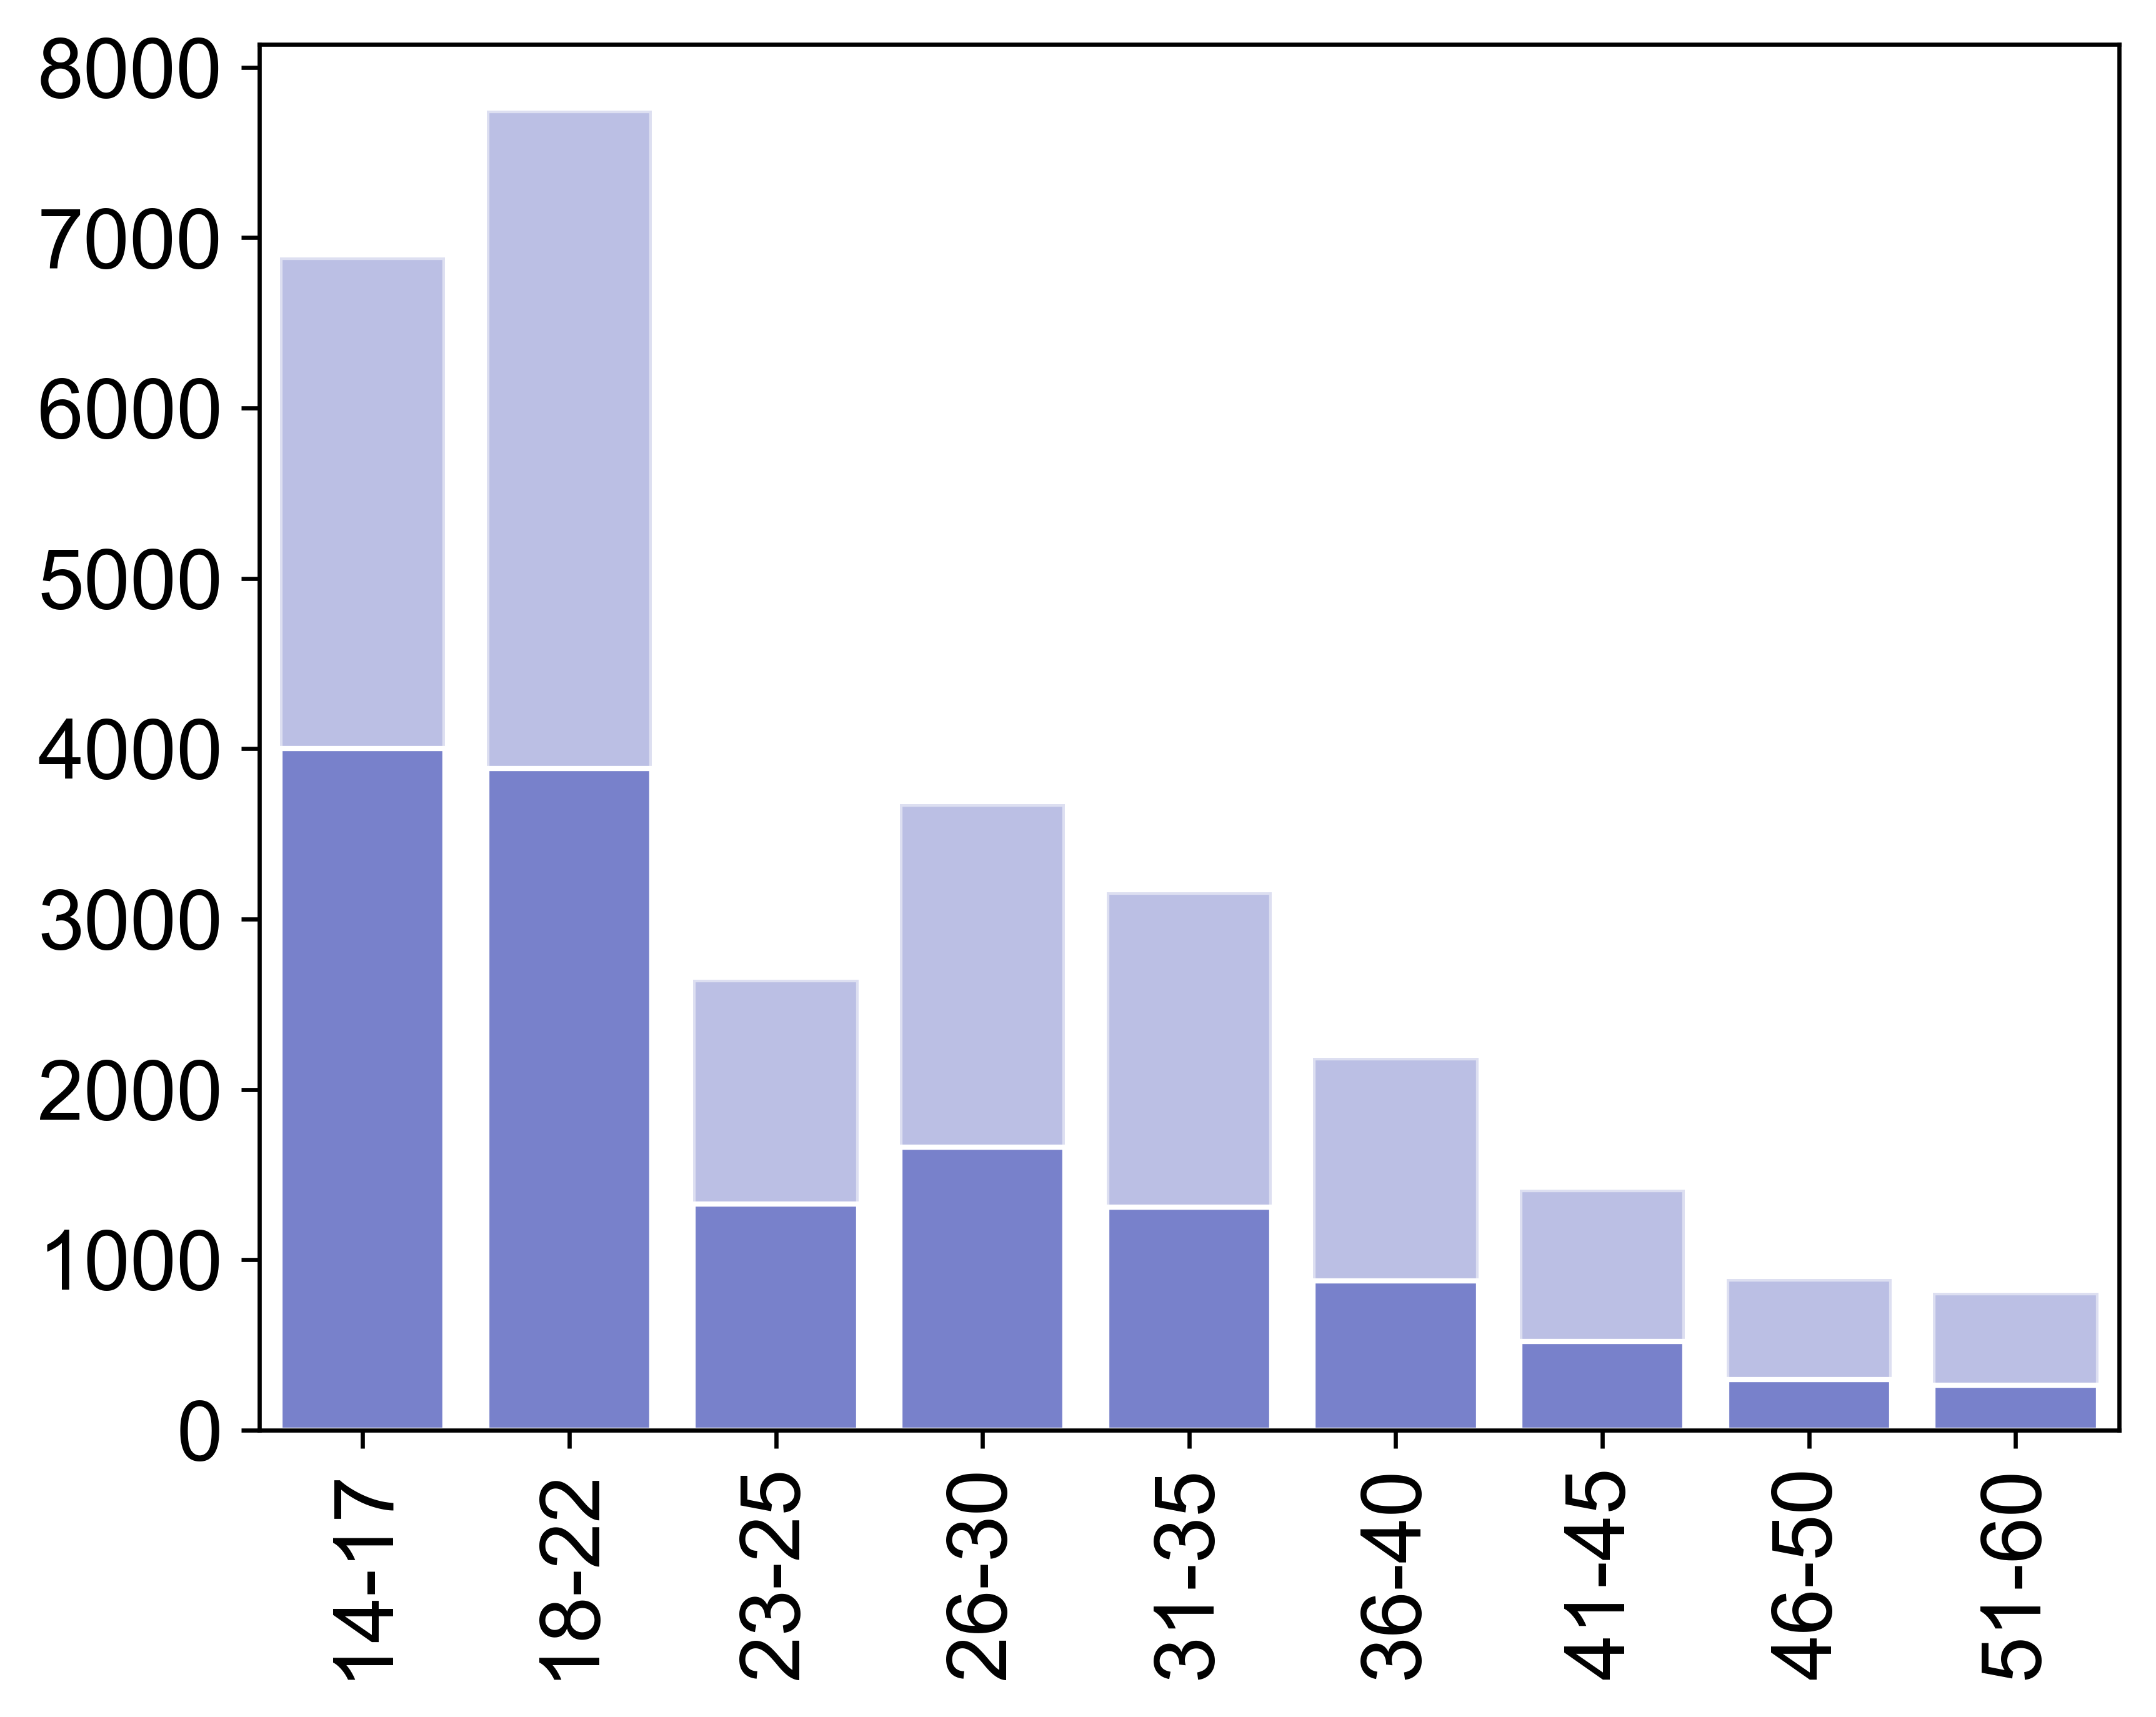

In [8]:
fig, ax = plt.subplots(dpi = 600)
sns.set_style("darkgrid", rc={'figure.facecolor': 'F9F9F9'})
sns.barplot(res_all, x="age_category", y="total_people",estimator=sum, errorbar=None, color="#6A76D9", alpha = 0.5)
sns.barplot(res_all_new, x = "age_category", y = "cancelled_trial_flg", estimator=sum, errorbar=None, color="#6A76D9")
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_yticklabels(np.around(np.arange(0,8100,1000), decimals=2), size = 16)
ax.set_xticklabels(new_column[1:10], size = 16, rotation = 90)
fig.savefig(r"../images/cancelled_trial_per_age_category_countplot.png")

In [91]:
issled = "region_size"
values = list(df[issled].dropna().unique())
print(values)
fig, axes = plt.subplots(len(values), 2, figsize = (16, len(values)*9), dpi = 400)
for j, tuple in enumerate(zip(values, axes)):
    value, axs = tuple
    df.age_category = df.age_category.apply(f)
    res = pl.from_pandas(df[df[issled] == value]).group_by("age_category").agg(
        total_people = pl.col("cancelled_trial").count(),
        cancelled_trial = pl.col("cancelled_trial").sum(),
        fraction_cancelled = pl.col("cancelled_trial").mean(),
        cancelled_trial_flg = pl.col("cancelled_trial"),
        std = pl.col("cancelled_trial").std(),
        se = pl.col("cancelled_trial").std()/(pl.col("cancelled_trial").count()**0.5),
        ci_95p = (pl.col("cancelled_trial").std()/(pl.col("cancelled_trial").count()**0.5))*1.96
    ).to_pandas()
    res = res.sort_values(by="age_category").reset_index(drop=True)
    res = res.loc[(res["age_category"] < 11) & (res["age_category"] > 1)]
    res.age_category = res.age_category.apply(lambda x: x-1)
    res_new = res.explode("cancelled_trial_flg")
    res_new.cancelled_trial_flg = pd.to_numeric(res.explode("cancelled_trial_flg").cancelled_trial_flg)

    sns.set_style("darkgrid", rc={'figure.facecolor': 'F9F9F9'})
    sns.regplot(data=res_new, x = "age_category", y = "cancelled_trial_flg",scatter=False, logistic=True, color="#6A76D9", ax=axs[0])
    sns.regplot(data=res_new, x = "age_category", y = "cancelled_trial_flg",scatter=False, color="#F05C24", ax=axs[1])
    sns.regplot(data=res_all_new, x = "age_category", y = "cancelled_trial_flg",scatter=False, logistic=True, color="#F564D8", ax=axs[0], line_kws={'alpha':0.5})
    sns.regplot(data=res_all_new, x = "age_category", y = "cancelled_trial_flg",scatter=False, color="#F564D8", ax=axs[1], line_kws={'alpha':0.5})
    # sns.scatterplot(data=res, x = "age_category", y = 0, size = res["total_people"] - res["cancelled_trial"], ax = axs[0], legend=False, color="#6A76D9", sizes=(40,400))
    # sns.scatterplot(data=res, x = "age_category", y = 0, size = res["total_people"] - res["cancelled_trial"], ax = axs[1], legend=False, color="#F05C24", sizes=(40,400))
    # sns.scatterplot(data=res, x = "age_category", y = 1, size = res["cancelled_trial"], ax = axs[0], legend=False, color="#6A76D9", sizes=(40,400))
    # sns.scatterplot(data=res, x = "age_category", y = 1, size = res["cancelled_trial"], ax = axs[1], legend=False, color="#F05C24", sizes=(40,400))
    sns.scatterplot(data=res_new, x = "age_category", y = "fraction_cancelled", ax=axs[0])
    sns.scatterplot(data=res_new, x = "age_category", y = "fraction_cancelled", ax=axs[1])
    axs[0].errorbar(data=res_new, x = "age_category", y = "fraction_cancelled", yerr="ci_95p", fmt="none", capsize=4)
    axs[1].errorbar(data=res_new, x = "age_category", y = "fraction_cancelled", yerr="ci_95p", fmt="none", capsize=4)
    axs[1].set_yticks(np.arange(0,1.1,0.1))
    axs[0].set_yticks(np.arange(0,1.1,0.1))
    axs[0].set_yticklabels(np.around(np.arange(0,1.1,0.1), 1), size = 16)
    axs[1].set_yticklabels(np.around(np.arange(0,1.1,0.1), 1), size = 16)
    axs[0].set_xticks(np.arange(1,9.4,1))
    axs[1].set_xticks(np.arange(1,9.4,1))
    axs[0].set_xticklabels(new_column[1:10], size = 16, rotation = 90)
    axs[1].set_xticklabels(new_column[1:10], size = 16, rotation = 90)
    axs[0].set_xlabel(str(value).lower().capitalize())
    axs[1].set_xlabel(str(value).lower().capitalize())
    axs[0].set_ylabel(None)
    axs[1].set_ylabel(None)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
fig.savefig("../images/regplot.png")

['неизвестно', 'ГОРОД', 'СЕЛО', 'ПОСЕЛОК', 'МОСКВА', 'ПОСЕЛОК ГОРОДСКОГО ТИПА', 'ГОРОД-МИЛЛИОННИК', 'ДЕРЕВНЯ', 'САНКТ-ПЕТЕРБУРГ']


In [30]:
X = res_all_new.age_category #to_numpy()
Y = res_all_new.cancelled_trial_flg.to_numpy()
X = sm.add_constant(X)

lin_model = sm.OLS(Y, X)
bin_model = sm.Probit(Y, X)
lin_res = lin_model.fit()
bin_res = bin_model.fit()

print(lin_res.summary(), bin_res.summary())

Optimization terminated successfully.
         Current function value: 0.681935
         Iterations 4
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     621.6
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          8.61e-136
Time:                        11:35:11   Log-Likelihood:                -21006.
No. Observations:               29396   AIC:                         4.202e+04
Df Residuals:                   29394   BIC:                         4.203e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [101]:
res_all_new.age_category = res_all_new.age_category.apply(lambda x: x-1)

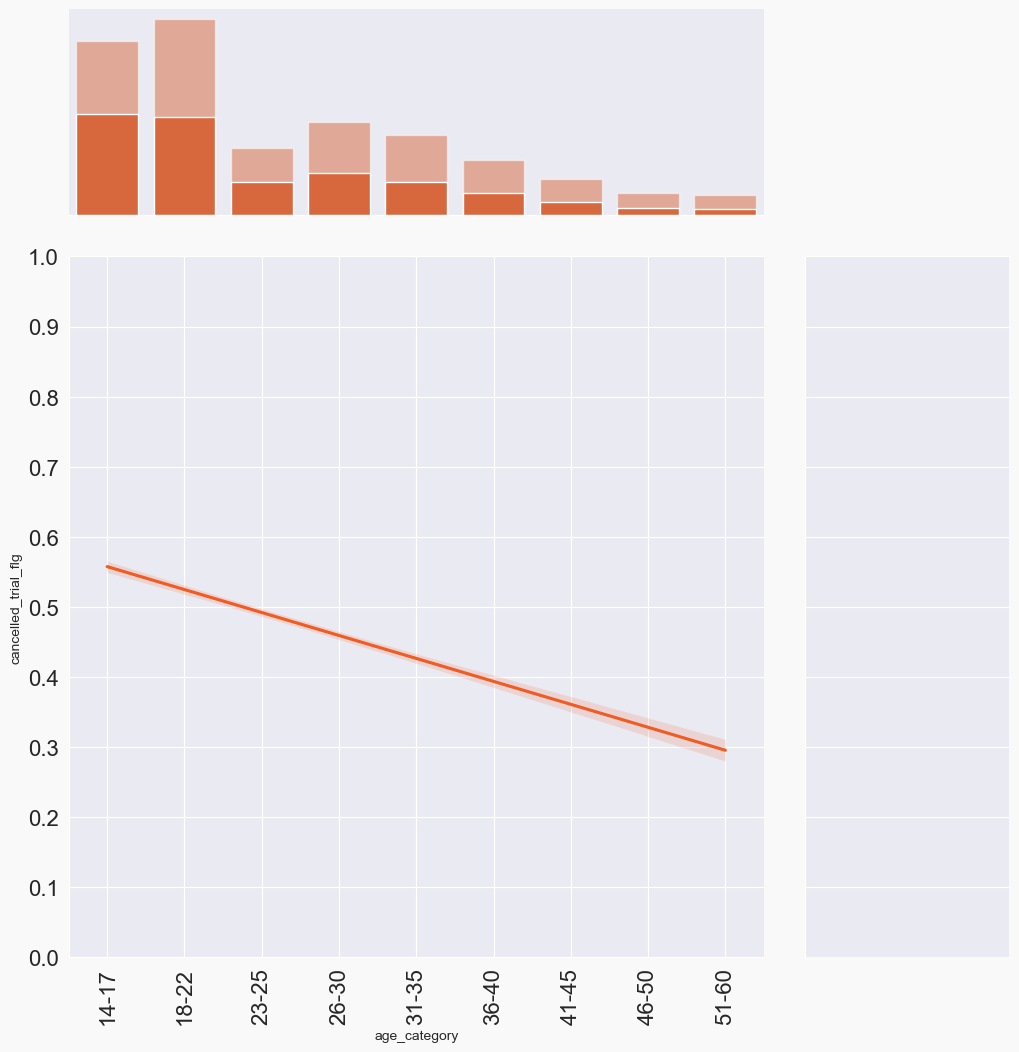

In [82]:
g = sns.JointGrid(ratio=3, height=10, ylim=(0,1), xlim=(0,8))
logistic = 0
sns.set_style("darkgrid", rc={'figure.facecolor': 'F9F9F9'})
sns.regplot(data=res_all_new, x = "age_category", y ="cancelled_trial_flg",scatter=False, logistic=[True, False][logistic], color = ["#6A76D9", "#F05C24"][logistic], ax=g.ax_joint)
sns.barplot(data=res_all, x="age_category", y= "total_people", alpha = 0.5, estimator=sum, errorbar=None, color = ["#6A76D9", "#F05C24"][logistic], ax = g.ax_marg_x)
sns.barplot(data=res_all, x = "age_category", y = "cancelled_trial", estimator=sum, errorbar=None, color=["#6A76D9", "#F05C24"][logistic], ax = g.ax_marg_x)
# sns.scatterplot(data=res_all_new, x = "age_category", y = "fraction_cancelled", ax=g.ax_joint)
# g.ax_joint.errorbar(data=res_all_new, x = "age_category", y = "fraction_cancelled", yerr="ci_95p", fmt="none", capsize=4)
g.ax_joint.set_xticks(np.arange(0,8.4,1))
g.ax_joint.set_yticks(np.arange(0,1.04,0.1))
g.ax_joint.set_yticklabels(np.around(np.arange(0,1.04,0.1), decimals=2), size = 16)
g.ax_joint.set_xticklabels(new_column[1:10], size = 16, rotation = 90)
g.savefig(r"../images/regplot_with_countplot.png", dpi = 400)

In [27]:
res_all_new.age_category.corr(res_all_new.cancelled_trial_flg)

-0.14390833655630286